## Notes
1. Torchaudio requires soundfile to be installed. [`pip install soundfile`]

## Load

In [45]:
from matplotlib import pyplot as plt
import torchaudio
import torch
import utils
from models import Wav2Vec, Wav2Vec_PARAMS

In [46]:
torchaudio.list_audio_backends()

['soundfile']

In [47]:
SOURCE_FILE = "data/mrbeast.wav"
SAMPLE_RATE = 16000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LABELS = ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')

print(f"Using {DEVICE}.")

Using cuda.


In [48]:
# url = "https://youtube.com/shorts/IQxea9UB1nQ?si=x1zMvnC591rhVwIv"  # Replace with your YouTube video URL
# output_path = "data/mrbeast.mp3"  # Replace with your desired output path
# utils.download_audio(url, output_path)

Error: [WinError 183] Cannot create a file when that file already exists: 'd:\\workspace\\s2t\\data/mrbeast.mp3'


In [49]:
# from os import path 
# from pydub import AudioSegment 
  
# # assign files 
# input_file = output_path
# output_file = output_path.replace(".mp3", ".wav")
  
# # convert mp3 file to wav file 
# sound = AudioSegment.from_file(input_file, format="mp4")
# sound.export(output_file, format="wav") 

<_io.BufferedRandom name='data/mrbeast.wav'>

In [50]:
# # Load
waveform, sample_rate = torchaudio.load(SOURCE_FILE, format="wav")

# # Slicing
offset, num_frames = 0, 44100
waveform_slice, sample_rate_slice = torchaudio.load(SOURCE_FILE, format="wav", frame_offset=offset, num_frames=num_frames)

# utils.plot_waveform(waveform, sample_rate)

## Save


In [51]:
# # To file
# import io
# torchaudio.save("output.wav", waveform, sample_rate=sample_rate)

# # To buffer
# buffer = io.BytesIO()
# torchaudio.save(buffer, waveform, sample_rate=sample_rate, format="wav")

# buffer.getvalue()[:50]

## Resampling

In [52]:
waveform, sample_rate = torchaudio.load(SOURCE_FILE, format="wav")
waveform = waveform.to(DEVICE)

if sample_rate != SAMPLE_RATE:
    waveform = torchaudio.functional.resample(waveform, sample_rate, SAMPLE_RATE)

In [53]:

model = Wav2Vec(Wav2Vec_PARAMS)
model.load_state_dict(torch.load("models/checkpoints/wav2vec2-base-960h.pt"))
model.to(DEVICE)


Wav2Vec(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametrizations): ModuleDict(
 

In [54]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)
    emission, _ = model(waveform)

# Feature Extractor + Encoder
# list[Tensor] <num_heads, (?,?,embed_size)>
print(f'{len(features)}, {features[0].shape}')

# Feature Extractor + Encoder + Aux
# Tensor <?, ?, vocab_size>
display(emission.shape)

12, torch.Size([2, 1425, 768])


torch.Size([2, 1425, 29])

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


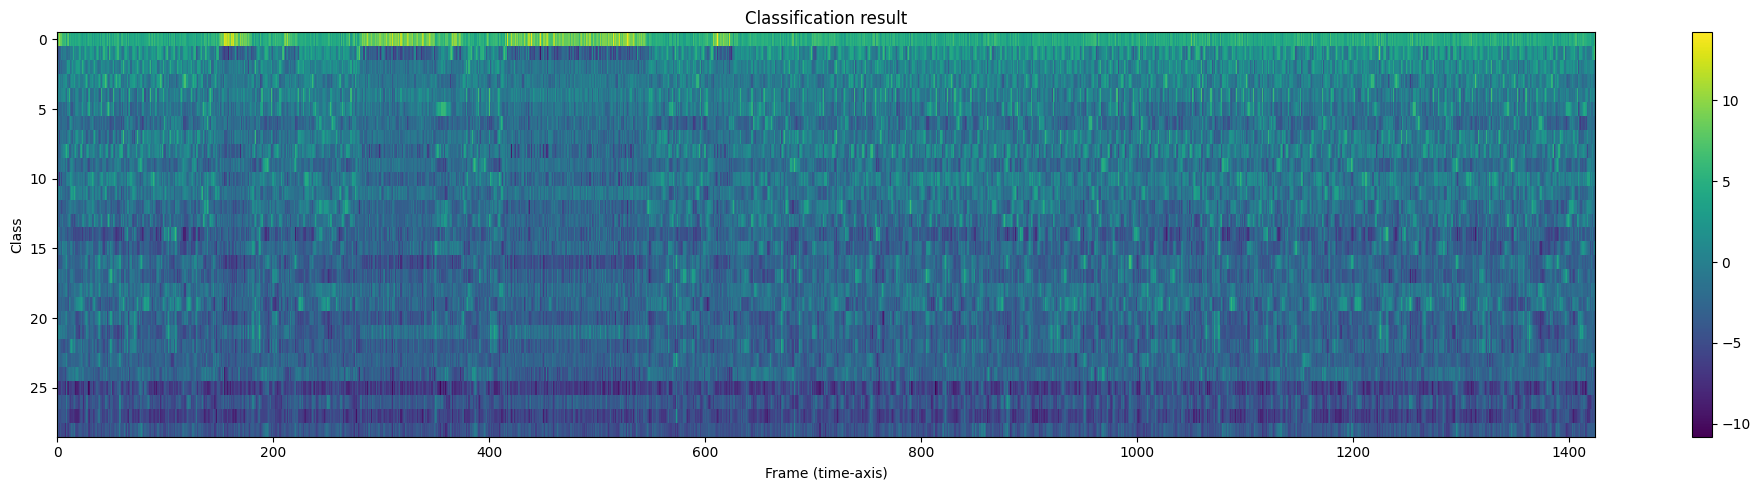

In [55]:
plt.figure(figsize=(20, 5))
plt.imshow(emission[0].cpu().T, interpolation="nearest", aspect='auto')
plt.title("Classification result")
plt.colorbar()
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", LABELS)

In [56]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1) # remove consecutive duplicates
        indices = [i for i in indices if i != self.blank] # remove blanks
        return "".join([self.labels[i] for i in indices]) # indices -> characters

In [57]:
decoder = GreedyCTCDecoder(labels=LABELS)
transcript = decoder(emission[0])

In [58]:
print(transcript)

HADHETORE|TA|TO|FAT|THIMA|I|SCAARATA|BIMEAT|TYA|HDONA|IBASA|AARA|TOLONITOLAD|OO|A|IS|A|SAAN|L|FOCE|FFT|LAOA|NOVILESSFEL|A|I|LAATA|HAI|A|TAT|I|LFOTA|ICATA|NOFRATIA||USHAO|MIT|O||LIABIE|MACNLES|TE|ATE|COMINGHITIFA|E|A|A|BA|BWASSAYERATOAA|MILA|HE|A|WAHE|A|HA|I|SARAT|B|MATI|IYON|HAOO|SAATIIRAITOSTATABLANA|TA|CHI|ULA|
